# 외국어 문장 판별

In [2]:
# 해당 텍스트가 어떤 언어인지 판정
# 알파벳의 출현횟수 확인
# 데이터를 그래프로 그리기
# 웹서비스 응용

## 외국어 판정
글자데이터 -> 벡터로?

In [3]:
# 글자 데이터를 벡터로 변경해서 사용해야 함  어떻게?

# '언어' 가 다르면 알파벳의 출변빈도가 다르다 <--- 언어학적으로 알려진 사실
# '언어' 마다 자주 사용하는 표현과 단어가 다르기 때문이다.

# 이를 활용하여 'a' 부터 'z' 까지의 출현 빈도(벡터화!)를 확인하고 이를 특징으로 사용

## 샘플데이터

In [4]:
# 언어별 풍부한 데이터가 있는 위키피디아 글자 사용.  

# lang/lang.zip 파일을 풀고 lang 폴더에 보면 샘플데이터 있슴

# lang
#   ├ test     테스트데이터 8개
#   └ train    학습데이터 20개        <-- 양이 부족하긴 하지만.  작게 테스트 할 용도

#  en 영어
#  fr 프랑스어
#  id 인도네시아어
#  tl  타갈로그어   <-- 필리핀에서 많이 사용하는 언어



### import

In [6]:
from sklearn import svm, metrics
# from sklearn.externals import joblib     # 학습내용 저장
import joblib
import glob, os.path, re, json

# glob  : Filename globbing utility

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [7]:
# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False  



### 언어별 파일 구분
파일명 앞 2글자, 정규표현식 사용 -> ★결국 그 2글자가 label 역할을 하게 된다 ★

In [8]:
name = 'en-5.txt'
re.match(r'^[a-z]{2,}', name).group()

'en'

In [10]:
[0 for n in range(26)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### 텍스트를 읽어 들이고 출현빈도 조사하기

In [11]:
#  check_freq(파일이름)  수행결과  (tuple 이다)

# ([0.07595212187159957,
#   0.012840043525571273,
#   0.04570184983677911,
#   ...
#   ...
#   0.0006528835690968443,
#   0.02002176278563656,
#   0.0004352557127312296],
#  'en')

#  data 와 label 형태다

In [12]:
fname = r'D:\DevRoot\DataSet\lang\lang\train\en-1.txt'

In [14]:
# 파일이름
name = os.path.basename(fname)
lang = re.match(r'^[a-z]{2,}', name).group()
name, lang

('en-1.txt', 'en')

In [16]:
# 파일 전체 읽기
with open(fname, 'r', encoding='utf-8') as f:
    text = f.read()
    
text
text[:100]

'\n\n\n\nThe main Henry Ford Museum building houses some of the classrooms for the Henry Ford Academy\n\n\nH'

In [17]:
# 소문자 만들기
text = text.lower()
text[:100]

'\n\n\n\nthe main henry ford museum building houses some of the classrooms for the henry ford academy\n\n\nh'

In [18]:
# 알파벳 빈도 26개
cnt = [0 for n in range(26)]
cnt

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# text 안의 알파벳 빈도를 cnt 에 작성

In [23]:
for i in range(26):
    ch = chr(i + ord('a'))
    cnt[i] = text.count(ch)
    
cnt

[349,
 59,
 210,
 212,
 484,
 72,
 88,
 201,
 340,
 8,
 25,
 247,
 121,
 356,
 412,
 76,
 0,
 357,
 282,
 370,
 119,
 45,
 65,
 3,
 92,
 2]

In [24]:
# 정규화 하기
# 각 알파벳의 출현 빈도를 확률로 재계산
total = sum(cnt)
freq = list(map(lambda n: n /total, cnt))
freq

[0.07595212187159957,
 0.012840043525571273,
 0.04570184983677911,
 0.04613710554951034,
 0.10533188248095757,
 0.015669205658324265,
 0.019151251360174103,
 0.043743199129488576,
 0.07399347116430903,
 0.0017410228509249185,
 0.00544069640914037,
 0.05375408052230685,
 0.026332970620239392,
 0.07747551686615888,
 0.08966267682263329,
 0.016539717083786723,
 0.0,
 0.07769314472252448,
 0.061371055495103376,
 0.08052230685527748,
 0.02589771490750816,
 0.009793253536452665,
 0.014145810663764961,
 0.0006528835690968443,
 0.02002176278563656,
 0.0004352557127312296]

In [25]:
# 최종결과
freq, lang   # data, label   <-- 학습시킬 내용.  알파벳 빈도수의 벡터화가 이루어짐

([0.07595212187159957,
  0.012840043525571273,
  0.04570184983677911,
  0.04613710554951034,
  0.10533188248095757,
  0.015669205658324265,
  0.019151251360174103,
  0.043743199129488576,
  0.07399347116430903,
  0.0017410228509249185,
  0.00544069640914037,
  0.05375408052230685,
  0.026332970620239392,
  0.07747551686615888,
  0.08966267682263329,
  0.016539717083786723,
  0.0,
  0.07769314472252448,
  0.061371055495103376,
  0.08052230685527748,
  0.02589771490750816,
  0.009793253536452665,
  0.014145810663764961,
  0.0006528835690968443,
  0.02002176278563656,
  0.0004352557127312296],
 'en')

## 함수로 만들기

In [26]:
def check_freq(fname):
    name = os.path.basename(fname)   # 파일 이름
    lang = re.match(r'^[a-z]{2,}', name).group()  # 파일 앞 2글자 추출  (문자열 slicing으로 해도 될텐데?)
    with open(fname, "r", encoding='utf-8') as f:
        text = f.read()
    text = text.lower()  # 소문자 변환
    
    # 숫자 세기(출현빈도) 변수(cnt) 초기화
    cnt = []
    
    for i in range(26):
        ch = chr(i + ord('a'))
        cnt.append(text.count(ch))

    cnt
            
    # 정규화 하기.. normalizing.     
    # 각 알파벳의 출현 빈도를 확률로 재계산
    total = sum(cnt)
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)


In [27]:
check_freq(fname)

([0.07595212187159957,
  0.012840043525571273,
  0.04570184983677911,
  0.04613710554951034,
  0.10533188248095757,
  0.015669205658324265,
  0.019151251360174103,
  0.043743199129488576,
  0.07399347116430903,
  0.0017410228509249185,
  0.00544069640914037,
  0.05375408052230685,
  0.026332970620239392,
  0.07747551686615888,
  0.08966267682263329,
  0.016539717083786723,
  0.0,
  0.07769314472252448,
  0.061371055495103376,
  0.08052230685527748,
  0.02589771490750816,
  0.009793253536452665,
  0.014145810663764961,
  0.0006528835690968443,
  0.02002176278563656,
  0.0004352557127312296],
 'en')

#### glob()

In [28]:
glob.glob(r'D:\DevRoot\DataSet\lang\lang\train\*.txt')

['D:\\DevRoot\\DataSet\\lang\\lang\\train\\en-1.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\en-2.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\en-3.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\en-4.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\en-5.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\fr-10.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\fr-6.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\fr-7.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\fr-8.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\fr-9.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\id-11.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\id-12.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\id-13.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\id-14.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\id-15.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\tl-16.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\tl-17.txt',
 'D:\\DevRoot\\DataSet\\lang\\lang\\train\\tl-18.txt',
 'D:\\DevRoot\\Data

### 파일(들) 읽어 들이는 함수
학습용(train), 테스트용(test) 폴더 안의 파일들을 일괄 벡터화

In [29]:
# load_files(파일데이터 있는 경로)

# 결과 (리턴값)  dict 
# {
#    freqs :  [
#                     [0.034, 0.34, . ...  , 0.034],       <-- 알파벳의 빈도수
#                     [0.034, 0.34, . ...  , 0.034],
#                      ..
#                 ]
#    labels : ['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl']
# }

In [30]:
# 위와 같은 함수 정의하고
# 아래와 같이 하면      위의 데이터 형태 나오게 하기

# data = load_files("./lang/lang/train/*.txt")
# test = load_files("./lang/lang/test/*.txt")

In [31]:
def load_files(path):
    freqs = [] # 출현빈도
    labels = []  # 레이블
    
    # 해당 경로(path) 에 일치하는 file 들을 list 로 리턴
    file_list = glob.glob(path)
    
    for fname in file_list:
        r = check_freq(fname)
        
        freqs.append(r[0])   # 출현빈도 벡터(list) 자체를 freqs에 추가
        labels.append(r[1])  # label 값을 labels 리스트에 추가
        
    return {
        "freqs": freqs,
        "labels": labels
    }

In [32]:
data = load_files(r'D:\DevRoot\DataSet\lang\lang\train\*.txt')
test = load_files(r'D:\DevRoot\DataSet\lang\lang\test\*.txt')

In [40]:
len(data['freqs']), len(data['labels']), len(test['freqs']), len(test['labels'])

(20, 20, 8, 8)

#### json 저장해보기 
나중에 시각화에 사용

In [41]:
with open(r'D:\DevRoot\DataSet\lang\lang\freq.json', 'w', encoding='utf-8') as fp:
    json.dump([data, test], fp)

In [42]:
# 저장된 모양새 확인
!type D:\DevRoot\DataSet\lang\lang\freq.json

[{"freqs": [[0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296], [0.08417789436031954, 0.019911768212710148, 0.030404196971503518, 0.038869679265529984, 0.13699773458924527, 0.017407893167998092, 0.031238821986407535, 0.02742339334684631, 0.07535471563133421, 0.0026231071896983425, 0.009777035888875641, 0.042327411470132345, 0.024204125432216526, 0.05353523309884345, 0.06879694765708835, 0.020269464647669013, 0.005484678669369262, 0.09013950160963395, 0.07165851913675927, 0.07773935853105997, 0.030642

# 학습하기

In [43]:
clf = svm.SVC()
clf.fit(data['freqs'], data['labels'])

SVC()

## 예측하기

In [44]:
predict = clf.predict(test['freqs'])
predict

array(['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl'], dtype='<U2')

## 테스트

In [45]:
ac_score = metrics.accuracy_score(test['labels'], predict)
cl_report = metrics.classification_report(test['labels'], predict)
print('정답률 = ', ac_score)
print(cl_report)

정답률 =  1.0
              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          id       1.00      1.00      1.00         2
          tl       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



# 시각화
언어별 알파벳 빈도를 그래프로 확인하기

In [46]:
# json 파일 읽어오기
with open(r'D:\DevRoot\DataSet\lang\lang\freq.json', 'r', encoding='utf-8') as fp:
    freq = json.load(fp)
    
freq

[{'freqs': [[0.07595212187159957,
    0.012840043525571273,
    0.04570184983677911,
    0.04613710554951034,
    0.10533188248095757,
    0.015669205658324265,
    0.019151251360174103,
    0.043743199129488576,
    0.07399347116430903,
    0.0017410228509249185,
    0.00544069640914037,
    0.05375408052230685,
    0.026332970620239392,
    0.07747551686615888,
    0.08966267682263329,
    0.016539717083786723,
    0.0,
    0.07769314472252448,
    0.061371055495103376,
    0.08052230685527748,
    0.02589771490750816,
    0.009793253536452665,
    0.014145810663764961,
    0.0006528835690968443,
    0.02002176278563656,
    0.0004352557127312296],
   [0.08417789436031954,
    0.019911768212710148,
    0.030404196971503518,
    0.038869679265529984,
    0.13699773458924527,
    0.017407893167998092,
    0.031238821986407535,
    0.02742339334684631,
    0.07535471563133421,
    0.0026231071896983425,
    0.009777035888875641,
    0.042327411470132345,
    0.024204125432216526,
    0.

### 언어별 계산

#### 확률의 평균?
normalizing 한 값은 확률과 같다 (?)

In [48]:
# 첫번째 데이터에서 'b' 가 나온 확률 0.2
# 두번째 데이터에서 'b' 가 나온 확률 0.6

# 결국 'b' 가 나온 확률은 얼마인가?
#  (0.2 + 0.6) / 2

In [53]:
lang_dic = {}
for i, lbl in enumerate(freq[0]['labels']):
    print(i, lbl)
    print(freq[0]['freqs'][i])

0 en
[0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]
1 en
[0.08417789436031954, 0.019911768212710148, 0.030404196971503518, 0.038869679265529984, 0.13699773458924527, 0.017407893167998092, 0.031238821986407535, 0.02742339334684631, 0.07535471563133421, 0.0026231071896983425, 0.009777035888875641, 0.042327411470132345, 0.024204125432216526, 0.05353523309884345, 0.06879694765708835, 0.020269464647669013, 0.005484678669369262, 0.09013950160963395, 0.07165851913675927, 0.07773935853105997, 0.030642661

In [54]:
# 아래 결과 만들어 보자..  언어별 빈도수

# {
# 'en': [0.0739194768069211,  0.020681128178765107, ...  0.0008863430770681183],
# ‘fr’': [0.0739194768069211,  0.020681128178765107, ...  0.0008863430770681183],
# …
# }

In [57]:
lang_dic = {}
for i, lbl in enumerate(freq[0]['labels']):
    fq = freq[0]['freqs'][i]
    
    # 기존에 해당언어 없었으면 언어 label 추가
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
        
    # 있었으면 해당언어 label 누적해서 추가,  빈도(확률) 계속 더하면서 나누기 2
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2
    
    
lang_dic

{'en': [0.0739194768069211,
  0.020681128178765107,
  0.03350608129469494,
  0.03911174713526719,
  0.1310434467061397,
  0.018278876119248624,
  0.02237173917718133,
  0.05061138076323214,
  0.06999143032913047,
  0.0026036109120023895,
  0.007367475596989206,
  0.04416655190835253,
  0.025787366460804054,
  0.06338618458614578,
  0.0744698151997811,
  0.018506315265646986,
  0.0008635398475884717,
  0.068278597138231,
  0.06743078786678966,
  0.09119266371721824,
  0.02572836989124908,
  0.01045874461643153,
  0.02008086837355564,
  0.0032780118175258295,
  0.01599944721403975,
  0.0008863430770681183],
 'fr': [0.0765035930866893,
  0.012909515223940703,
  0.03658955304764068,
  0.05046404440305238,
  0.14852328629382922,
  0.012366312481167804,
  0.01613124569080846,
  0.01654464192913213,
  0.08410226872832097,
  0.0036892349824243875,
  0.0021386968318385055,
  0.06016934184823422,
  0.02853364192640589,
  0.07679474036588048,
  0.058255914298558045,
  0.0249402236312757,
  0.0054

#### DataFrame 만들기
시각화를 위해

In [60]:
asclist = [
    chr(n)
    for n in range(97, 97 + 26)
]

In [64]:
df = pd.DataFrame(lang_dic, index=asclist)
df

,en,fr,id,tl
a,0.073919,0.076504,0.171599,0.201979
b,0.020681,0.012910,0.025640,0.022360
c,0.033506,0.036590,0.007429,0.015670
d,0.039112,0.050464,0.040608,0.027269
e,0.131043,0.148523,0.081552,0.055009
f,0.018279,0.012366,0.007096,0.004491
g,0.022372,0.016131,0.040386,0.056326
h,0.050611,0.016545,0.018533,0.011768
i,0.069991,0.084102,0.092387,0.075942
j,0.002604,0.003689,0.007693,0.001994


#### 그래프 그리기

array([<AxesSubplot:title={'center':'en'}>,
       <AxesSubplot:title={'center':'fr'}>,
       <AxesSubplot:title={'center':'id'}>,
       <AxesSubplot:title={'center':'tl'}>], dtype=object)

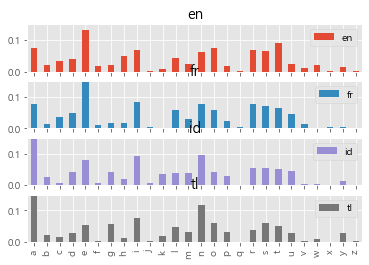

In [66]:
plt.style.use('ggplot')
df.plot(kind='bar', subplots=True, ylim=(0, 0.15))

### 학습데이터 저장

In [67]:
joblib.dump(clf, r'D:\DevRoot\DataSet\lang\lang\freq.pkl')
print('저장완료')

저장완료


# 웹 서비스

In [68]:
# 서버 실행시키기

# 파이썬에 기본적으로 내장된 간단한 웹서버 사용.
# 서버를 실행시킬 경로를 [root] 라 하면 
# 그 밑에 cgi-bin  이라는 이름의 디렉토리를 만들고 그 안에 서버스크립트로 실행될 파이썬 파일을 만듭니다.
# [root]
# └─[cgi-bin]
#         └─ lang-webapp.py
# 서버 실행시킬때는 명령프롬프트 root 지점에 가서
# >python -m http.server --cgi 8080

# 혹시 에러?=> OSError: [WinError 10013] 액세스 권한에 의해 숨겨진 소켓에 액세스를 시도했습니다
#  ↑ 포트번호 충돌 문제일 가능성 높다

# 그 다음 웹 브라우저에서  다음 url 로 파이썬 웹서버 접속
# http://localhost:8080/cgi-bin/lang-Webapp.py
